In [2]:
from lsst.ts.wep.utils import runProgram
import estimation_analysis_task as eat
import numpy as np
import os
from astropy.io import fits
from lsst.ts.imsim.opd_metrology import OpdMetrology
from lsst.ts.ofc import StateEstimator, OFCData, SensitivityMatrix
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
%load_ext autoreload
%autoreload 2

task = ClosedLoopTask()
butler_root_path = '/sdf/data/rubin/u/gmegias/projects/commissioning_sims/butler_wet001'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def _map_opd_to_zk(opd_file_path, rot_opd_in_deg: float, num_opd: int) -> np.ndarray:
    """Map the OPD to the basis of annular Zernike polynomial (Zk).

    OPD: optical path difference.

    Parameters
    ----------
    rot_opd_in_deg : float
        Rotate OPD in degree in the counter-clockwise direction.
    num_opd : int
        Number of OPD positions calculated.

    Returns
    -------
    numpy.ndarray
        Zk data from OPD. This is a 2D array. The row is the OPD index and
        the column is z4 to z22 in um. The order of OPD index is based on
        the file name.
    """

    # Map the OPD to the Zk basis and do the collection
    # Get the number of OPD locations by looking at length of fieldX
    num_of_zk = 19
    opd_metr = OpdMetrology()
    opd_data = np.zeros((num_opd, num_of_zk))
    for idx in range(num_opd):
        opd = fits.getdata(opd_file_path, idx)

        opd_rot = opd

        # z1 to z22 (22 terms)
        zk = opd_metr.get_zk_from_opd(opd_map=opd_rot)[0]

        # Only need to collect z4 to z22
        init_idx = 3
        opd_data[idx, :] = zk[init_idx : init_idx + num_of_zk]

    return opd_data*1e-3

In [4]:
# Run the pipeline for the 100 states
wfe_array = np.zeros((100, 4, 19))
for idx, state in tqdm(enumerate(np.arange(1,100)), total = 100):
    seq_num = 2000 + state
    butler_inst_name = 'Cam'

    list_of_wf_err = eat.compute_zernike_estimates(seq_num, butler_root_path, butler_inst_name)
    wfe = np.array(
        [sensor_wfe.annular_zernike_poly for sensor_wfe in list_of_wf_err]
    )

    wfe_array[idx, :, :] = wfe

0it [00:00, ?it/s]

In [5]:
sensor_names = np.array(
    [sensor_wfe.sensor_name for sensor_wfe in list_of_wf_err]
)

opd_array = np.zeros((100, 4, 19))

for idx, stae in tqdm(enumerate(np.arange(1,100)), total = 94):
    path = f'/sdf/data/rubin/u/gmegias/projects/commissioning_sims/WET-001/state_{state}/opd.fits'
    opd_array[idx, :, :] = _map_opd_to_zk(path, 0, 4)

  0%|          | 0/94 [00:00<?, ?it/s]

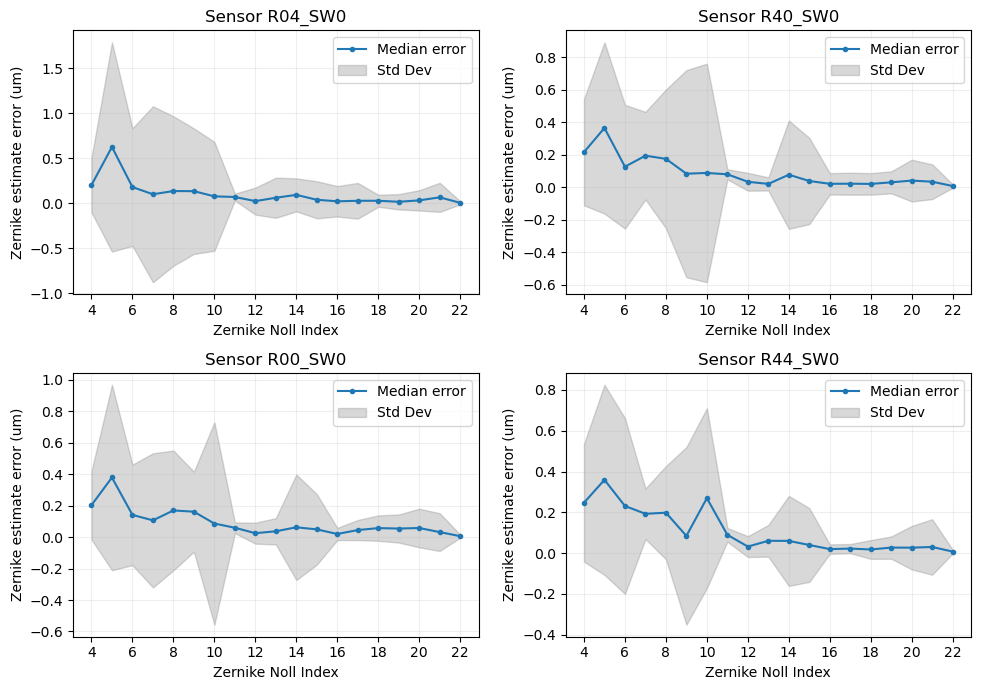

In [49]:
zernikes_error = np.abs(wfe_array - opd_array)
zernikes_error = np.delete(zernikes_error, 91, axis=0)
median_error = np.median(zernikes_error[:-1], axis = 0)
std_error = np.std(zernikes_error[:-1], axis = 0)
upper_bound = median_error + std_error
lower_bound = median_error - std_error

plt.figure(figsize = (10,7))
for idx in range(4):
    plt.subplot(2,2,idx + 1)
    # Plot the median error
    plt.plot(np.arange(4, 23), median_error[idx, :], '.-', label='Median error')

    # Fill between upper and lower bounds with gray transparency
    plt.fill_between(np.arange(4, 23), lower_bound[idx, :], upper_bound[idx, :], color='gray', alpha=0.3, label='Std Dev')

    # Add labels and legend
    plt.xticks(np.arange(4,23,2))
    plt.xlabel('Zernike Noll Index')
    plt.ylabel('Zernike estimate error (um)')
    plt.title(f'Sensor {sensor_names[idx]}')
    plt.legend()    
    plt.grid(alpha = 0.2)

plt.tight_layout()

NameError: name 'opd_array' is not defined

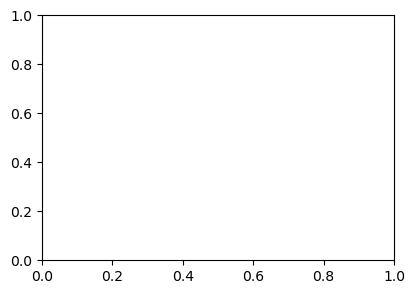

In [15]:
plt.figure(figsize = (10,7))

for idx in range(4):
    plt.subplot(2,2,idx + 1)
    plt.plot(np.arange(4,23), opd_array[1, idx, :], '.-', label = 'True zernikes')
    plt.plot(np.arange(4,23),wfe_array[1, idx, :], '.-', label = 'Estimated zernikes')
    plt.title(sensor_names[idx])
    plt.xticks(np.arange(4,23,2))
    plt.xlabel('Zernike index')
    plt.ylabel('um')
    plt.legend()

plt.tight_layout()

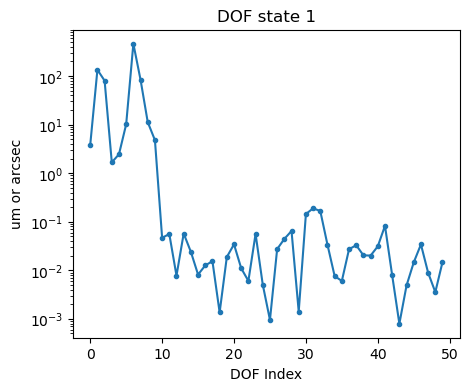

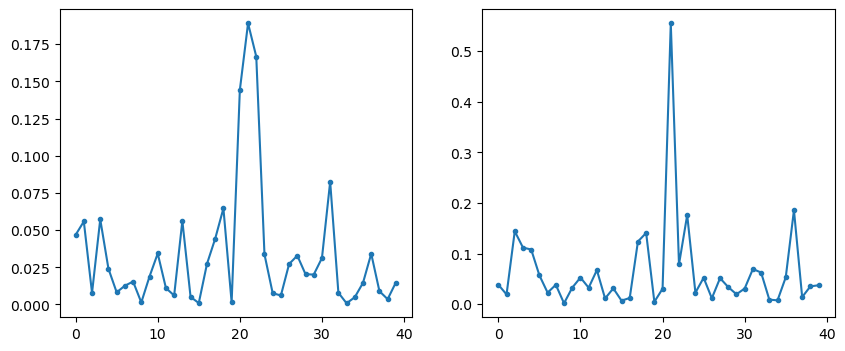

In [10]:
dof_dataset = np.load('dof_dataset_new.npy')

plt.figure(figsize = (10,4))

plt.subplot(1,2,1)
plt.semilogy(dof_dataset[0, :], '.-')
plt.xlabel('DOF Index')
plt.ylabel('um or arcsec')
plt.title('DOF state 1')

plt.subplot(1,2,2)
plt.semilogy(dof_dataset[29, :], '.-')
plt.xlabel('DOF Index')
plt.ylabel('um or arcsec')
plt.title('DOF state 29')

In [66]:

dof_dataset = np.load('dof_dataset_new.npy')
optical_states = np.zeros((100, 50))

ofc_data = OFCData('lsst')
state_estimator = StateEstimator(ofc_data, rcond=1e-3)

for idx, state in tqdm(enumerate(np.arange(1,100)), total = 99):
    optical_state = state_estimator.dof_state(
        'R', wfe_array[idx, ...], sensor_names, 0.0
    )
    optical_states[idx, :] = optical_state


  0%|          | 0/99 [00:00<?, ?it/s]

Text(0.5, 0, 'DOF index')

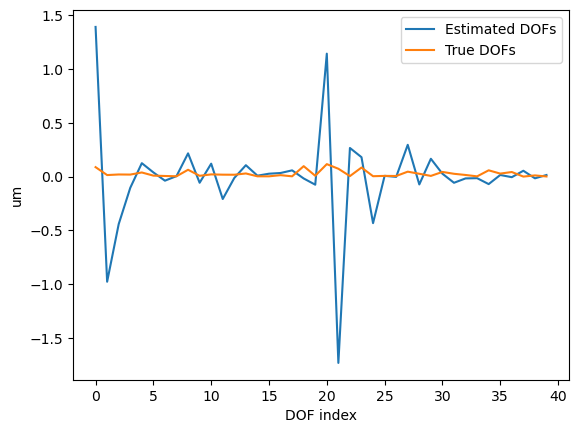

In [97]:
state_id = 1
plt.plot(optical_states[state_id, 10:], label = 'Estimated DOFs')
plt.plot(dof_dataset[state_id, 10:], label = 'True DOFs')
plt.legend()
plt.ylabel('um')
plt.xlabel('DOF index')

Text(0.5, 0.98, 'Estimated vs injected optical state for state 1')

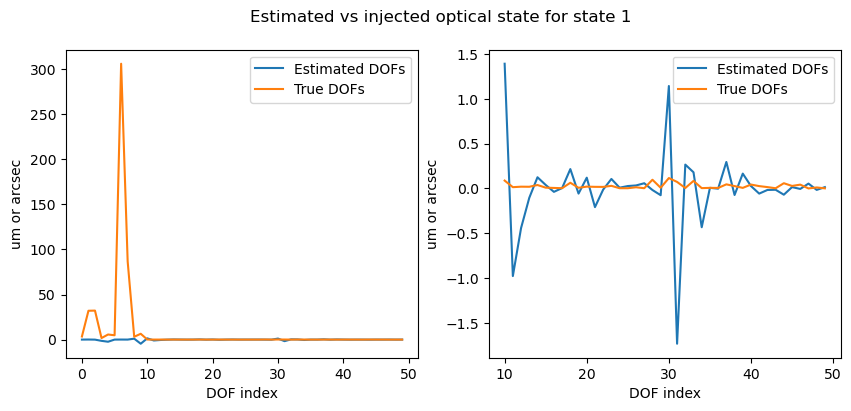

In [57]:
state_id = 1
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(optical_states[state_id, :], label = 'Estimated DOFs')
plt.plot(dof_dataset[state_id, :], label = 'True DOFs')
plt.legend()
plt.ylabel('um or arcsec')
plt.xlabel('DOF index')

plt.subplot(1,2,2)
plt.plot(np.arange(10,50), optical_states[state_id, 10:], label = 'Estimated DOFs')
plt.plot(np.arange(10,50), dof_dataset[state_id, 10:], label = 'True DOFs')
plt.legend()
plt.ylabel('um or arcsec')
plt.xlabel('DOF index')

plt.suptitle('Estimated vs injected optical state for state 1')

In [59]:
def compute_sensitivity_matrix():
    field_angles = [
        ofc_data.sample_points[sensor] for sensor in sensor_names
    ]
    
    dz_sensitivity_matrix = SensitivityMatrix(ofc_data)

    # Evaluate sensitivity matrix at sensor positions
    sensitivity_matrix = dz_sensitivity_matrix.evaluate(
        field_angles, 0.0
    )

    # Select sensitivity matrix only at used zernikes
    sensitivity_matrix = sensitivity_matrix[
        :, dz_sensitivity_matrix.ofc_data.zn3_idx, :
    ]

    # Reshape sensitivity matrix to dimensions
    # (#zk * #sensors, # dofs) = (19 * #sensors, 50)
    size = sensitivity_matrix.shape[2]
    sensitivity_matrix = sensitivity_matrix.reshape((-1, size))

    # Select sensitivity matrix only at used degrees of freedom
    sensitivity_matrix = sensitivity_matrix[
        ..., dz_sensitivity_matrix.ofc_data.dof_idx
    ]

    return sensitivity_matrix

sensitivity_matrix = compute_sensitivity_matrix()

In [67]:
# Create an empty array to store the results
zk_reconstructed_expanded = np.zeros((100, 4, 19))

# Iterate over the optical states
for idx in range(100):
    # Perform the operation for each optical state
    zk_reconstructed = sensitivity_matrix @ optical_states[idx, :]
    zk_reconstructed_expanded[idx, :, :] = zk_reconstructed.reshape(4, 19)

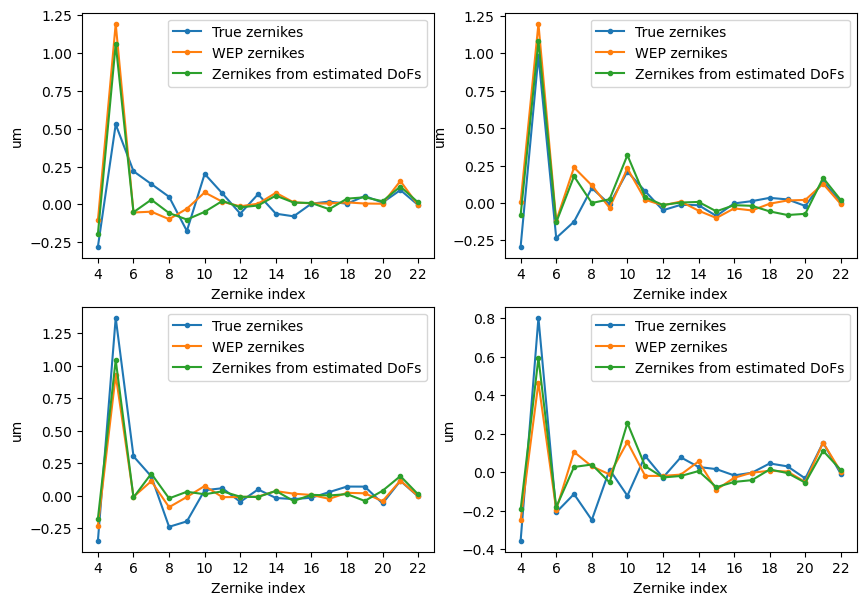

In [68]:
from matplotlib import pyplot as plt
plt.figure(figsize = (10,7))

for idx in range(4):
    plt.subplot(2,2,idx + 1)
    plt.plot(np.arange(4,23), opd_array[1, idx, :], '.-', label = 'True zernikes')
    plt.plot(np.arange(4,23), wfe_array[1, idx, :], '.-', label = 'WEP zernikes')
    plt.plot(np.arange(4,23), zk_reconstructed_expanded[1, idx, :], '.-', label = 'Zernikes from estimated DoFs')
    plt.xlabel('Zernike index')
    plt.xticks(np.arange(4,23,2))
    plt.ylabel('um')
    plt.legend()

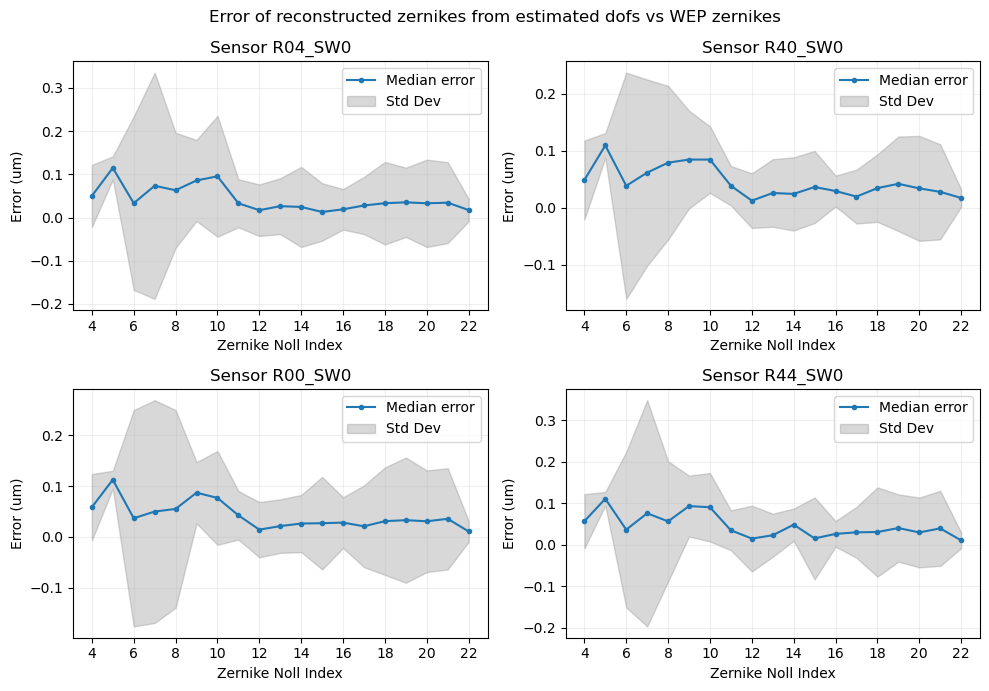

In [69]:
zernikes_error = np.abs(wfe_array - zk_reconstructed_expanded)
zernikes_error = np.delete(zernikes_error, 91, axis=0)
median_error = np.median(zernikes_error[:-1], axis = 0)
std_error = np.std(zernikes_error[:-1], axis = 0)
upper_bound = median_error + std_error
lower_bound = median_error - std_error

plt.figure(figsize = (10,7))
for idx in range(4):
    plt.subplot(2,2,idx + 1)
    # Plot the median error
    plt.plot(np.arange(4, 23), median_error[idx, :], '.-', label='Median error')

    # Fill between upper and lower bounds with gray transparency
    plt.fill_between(np.arange(4, 23), lower_bound[idx, :], upper_bound[idx, :], color='gray', alpha=0.3, label='Std Dev')

    # Add labels and legend
    plt.xticks(np.arange(4,23,2))
    plt.xlabel('Zernike Noll Index')
    plt.ylabel('Error (um)')
    plt.title(f'Sensor {sensor_names[idx]}')
    plt.legend()    
    plt.grid(alpha = 0.2)

plt.suptitle('Error of reconstructed zernikes from estimated dofs vs WEP zernikes')
plt.tight_layout()